In [1]:
import pandas as pd 
import numpy as np
from sentence_transformers import SentenceTransformer, SentenceTransformerTrainer, losses, models, SentenceTransformerTrainingArguments
from datasets import Dataset
import torch

In [2]:
train_df = pd.read_csv('train_ajt_df.csv', index_col=0)
test_df = pd.read_csv('test_ajt_df.csv', index_col=0)

In [3]:
df = pd.read_csv("ajt_dataset.csv")

df['type_mistake'] = df['type_mistake'].apply(lambda x: "речевая" if x == "лексическая" else x)
df['type_mistake'] = df['type_mistake'].apply(lambda x: "речевая+лексическая" if x == "речевая" else x)

df['type_mistake'] = df['type_mistake'].apply(lambda x: "грамматическая" if x == "пунктуационная" else x)
df['type_mistake'] = df['type_mistake'].apply(lambda x: "грамматическая+пунктуационная" if x == "грамматическая" else x)

df['type_mistake'] = df['type_mistake'].apply(lambda x: "стилистическая" if x == "логическая" else x)
df['type_mistake'] = df['type_mistake'].apply(lambda x: "стилистическая+логическая" if x == "стилистическая" else x)

In [4]:
train_df = pd.concat([train_df, df.loc[train_df.index]['type_mistake'], ], axis=1).reset_index(drop=True)
test_df = pd.concat([test_df, df.loc[test_df.index]['type_mistake'], ], axis=1).reset_index(drop=True)

In [5]:
train_df.type_mistake.value_counts()

type_mistake
нет ошибки                       361
речевая+лексическая               85
стилистическая+логическая         83
грамматическая+пунктуационная     59
Name: count, dtype: int64

In [6]:
# label_mapper = {"нет ошибки": 0, "речевая+лексическая": 1, "стилистическая+логическая": 2, "грамматическая+пунктуационная": 3}
# reverse_label_mapper = {0: "нет ошибки", 1: "речевая+лексическая", 2: "стилистическая+логическая", 3: "грамматическая+пунктуационная"}

label_mapper = {"нет ошибки": -1, "речевая+лексическая": 0, "стилистическая+логическая": 1, "грамматическая+пунктуационная": 2}
reverse_label_mapper = {-1: "нет ошибки", 0: "речевая+лексическая", 1: "стилистическая+логическая", 2: "грамматическая+пунктуационная"}

In [7]:
train_df['type_mistake'] = train_df['type_mistake'].map(label_mapper)
test_df['type_mistake'] = test_df['type_mistake'].map(label_mapper)

train_df['text'] = train_df['text'].astype(str)
test_df['text'] = test_df['text'].astype(str)

In [8]:
train_df = train_df[['text', 'type_mistake']]
test_df = test_df[['text', 'type_mistake']]

In [9]:
# for only mistakes
train_df = train_df[train_df.type_mistake != -1].reset_index(drop=True)
test_df = test_df[test_df.type_mistake != -1].reset_index(drop=True)

In [10]:
train_df = train_df.rename(columns={'text': 'sentence', 'type_mistake': 'label'})
test_df = test_df.rename(columns={'text': 'sentence', 'type_mistake': 'label'})

In [11]:
train_ds = Dataset.from_pandas(train_df)
test_ds = Dataset.from_pandas(test_df)

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Train with triplet losss

In [13]:
model_name = "DeepPavlov/rubert-base-cased"
model = SentenceTransformer(model_name)
embedding_model = models.Transformer(model_name, max_seq_length=128)
# create sentence-transformers model
pooling_model = models.Pooling(embedding_model.get_word_embedding_dimension(), pooling_mode_cls_token=True, pooling_mode_mean_tokens=False, include_prompt=False)
model = SentenceTransformer(modules=[embedding_model, pooling_model])
model.to(device)

No sentence-transformers model found with name DeepPavlov/rubert-base-cased. Creating a new one with mean pooling.
Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': True, 'pooling_mode_mean_tokens': False, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': False})
)

In [14]:
loss = losses.BatchHardTripletLoss(model, distance_metric=losses.BatchHardTripletLossDistanceFunction.eucledian_distance)

In [17]:
args = SentenceTransformerTrainingArguments(
    output_dir="triplet/rubert-base-cased-rebalanced-only-mistakes",
    num_train_epochs=5,
    per_device_train_batch_size=16,
    learning_rate=2e-5,
    warmup_ratio=0.1,
    bf16=True,
    logging_strategy="epoch",

)

In [18]:
trainer = SentenceTransformerTrainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    loss=loss,
)

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [ ]:
trainer.train()

# Vizalization

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from transformers import AutoTokenizer, AutoModel

## Trained with triplet loss with no mistakes

### Base Model

In [ ]:
base_model_name = "DeepPavlov/rubert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(base_model_name)
base_model = AutoModel.from_pretrained(base_model_name)
base_model.to(device)

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(119547, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=Fals

In [ ]:
def get_embeddings(texts, model):    
    encoded_input = tokenizer(texts, padding=True, truncation=True, max_length=128, return_tensors='pt').to(device)
    with torch.no_grad():
        model_output = model(**encoded_input)
    embeddings = model_output.pooler_output
    embeddings = torch.nn.functional.normalize(embeddings)
    return embeddings.cpu().numpy()

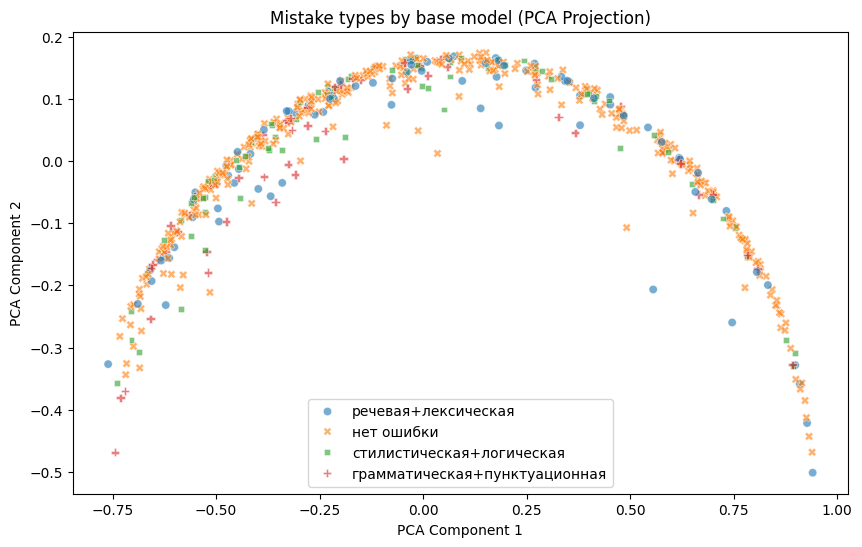

In [ ]:
pca = PCA(n_components=2)
train_embeddings = get_embeddings(train_df.text.values.tolist(), base_model)
y_train = train_df.type_mistake.map(reverse_label_mapper).values.tolist()
X_2d_train = pca.fit_transform(train_embeddings)


plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_2d_train[:, 0], y=X_2d_train[:, 1], hue=y_train, style=y_train, palette="tab10", alpha=0.6)

plt.legend()
plt.title("Mistake types by base model (PCA Projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

### Tuned model

In [10]:
embedding_model_path = "/home/shared/nk/dl2024/AJT/triplet/rubert-base-cased-rebalanced/checkpoint-740"
embedding_model = SentenceTransformer(embedding_model_path)
embedding_model.to(device)

SentenceTransformer(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': True, 'pooling_mode_mean_tokens': False, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': False})
)

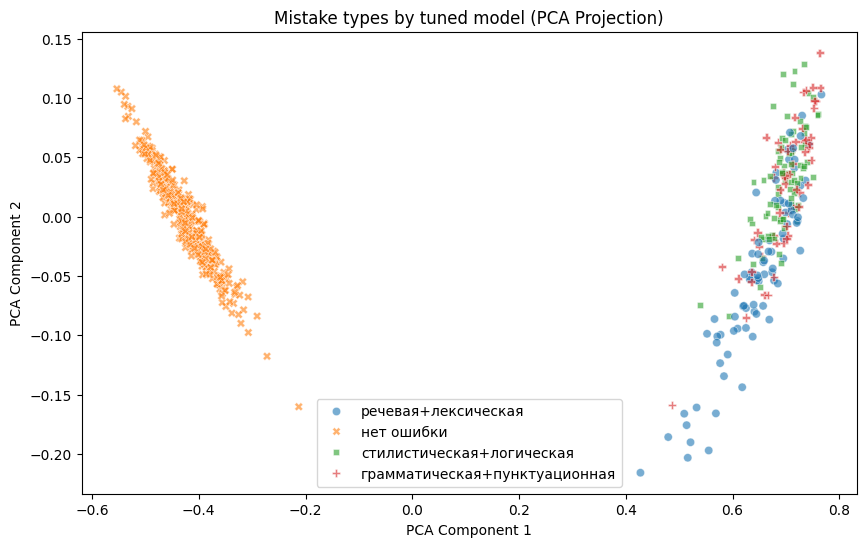

In [13]:
pca = PCA(n_components=2)
train_embeddings = embedding_model.encode(train_df.text.values.tolist(), normalize_embeddings=True)
y_train = train_df.type_mistake.map(reverse_label_mapper).values.tolist()
X_2d_train = pca.fit_transform(train_embeddings)


plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_2d_train[:, 0], y=X_2d_train[:, 1], hue=y_train, style=y_train, palette="tab10", alpha=0.6)

plt.legend()
plt.title("Mistake types by tuned model (PCA Projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

## Trained with triplet loss with only mistakes

### Base Model

In [12]:
base_model_name = "DeepPavlov/rubert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(base_model_name)
base_model = AutoModel.from_pretrained(base_model_name)
base_model.to(device)

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(119547, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=Fals

In [13]:
def get_embeddings(texts, model):    
    encoded_input = tokenizer(texts, padding=True, truncation=True, max_length=128, return_tensors='pt').to(device)
    with torch.no_grad():
        model_output = model(**encoded_input)
    embeddings = model_output.pooler_output
    embeddings = torch.nn.functional.normalize(embeddings)
    return embeddings.cpu().numpy()

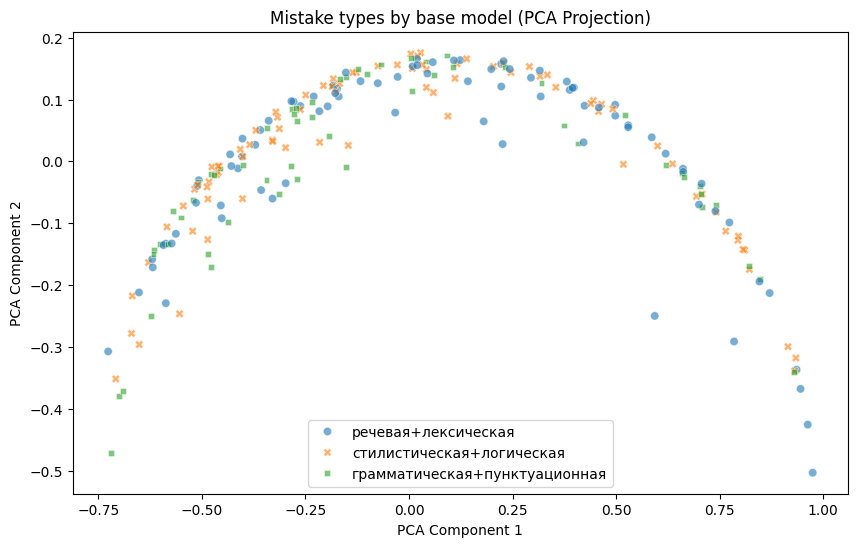

In [14]:
pca = PCA(n_components=2)
train_embeddings = get_embeddings(train_df.text.values.tolist(), base_model)
y_train = train_df.type_mistake.map(reverse_label_mapper).values.tolist()
X_2d_train = pca.fit_transform(train_embeddings)


plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_2d_train[:, 0], y=X_2d_train[:, 1], hue=y_train, style=y_train, palette="tab10", alpha=0.6)

plt.legend()
plt.title("Mistake types by base model (PCA Projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

### Tuned model

In [15]:
embedding_model_path = "/home/shared/nk/dl2024/AJT/triplet/rubert-base-cased-rebalanced-only-mistakes/checkpoint-150"
embedding_model = SentenceTransformer(embedding_model_path)
embedding_model.to(device)

SentenceTransformer(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': True, 'pooling_mode_mean_tokens': False, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': False})
)

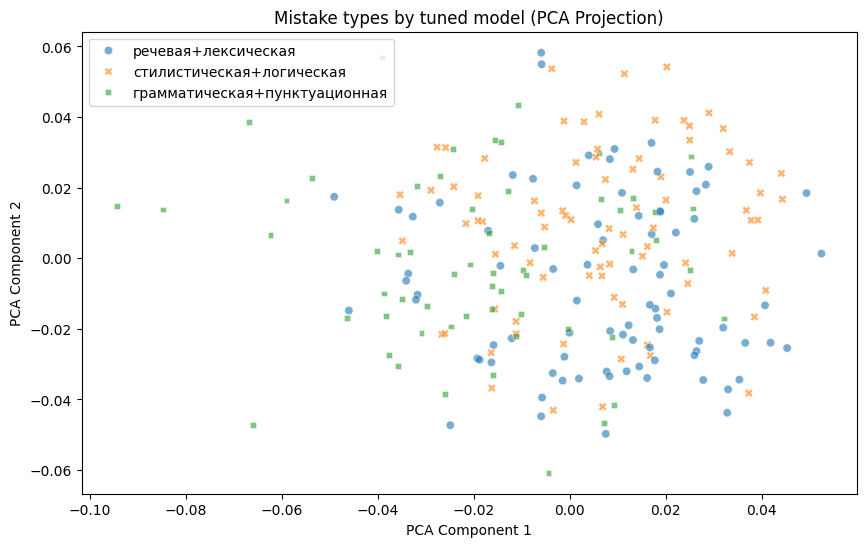

In [16]:
pca = PCA(n_components=2)
train_embeddings = embedding_model.encode(train_df.text.values.tolist(), normalize_embeddings=True)
y_train = train_df.type_mistake.map(reverse_label_mapper).values.tolist()
X_2d_train = pca.fit_transform(train_embeddings)


plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_2d_train[:, 0], y=X_2d_train[:, 1], hue=y_train, style=y_train, palette="tab10", alpha=0.6)

plt.legend()
plt.title("Mistake types by tuned model (PCA Projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

# Train classic model

In [10]:
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef

In [13]:
# embedding_model_path = "/home/shared/nk/dl2024/AJT/triplet/rubert-base-cased-rebalanced/checkpoint-740"
embedding_model_path = "/home/shared/nk/dl2024/AJT/triplet/rubert-base-cased-rebalanced-only-mistakes/checkpoint-150"
embedding_model = SentenceTransformer(embedding_model_path)
embedding_model.to(device)

SentenceTransformer(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': True, 'pooling_mode_mean_tokens': False, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': False})
)

In [14]:
# train_embeddings = embedding_model.encode(train_df.text.values.tolist())
# test_embeddings = embedding_model.encode(test_df.text.values.tolist())
# if multi
train_embeddings = embedding_model.encode(train_df[train_df.type_mistake != -1].text.values.tolist())
test_embeddings = embedding_model.encode(test_df[test_df.type_mistake != -1].text.values.tolist())

In [15]:
X_train = train_embeddings
# y_train_binary = train_df.is_mistake.values
y_train_multi = train_df[train_df.type_mistake != -1].type_mistake.values

X_test = test_embeddings
# y_test_binary = test_df.is_mistake.values
y_test_multi = test_df[test_df.type_mistake != -1].type_mistake.values

## LGBM

In [16]:
clf = lgb.LGBMClassifier(random_state=123, verbose=-1)
# clf.fit(X_train, y_train_binary)
clf.fit(X_train, y_train_multi)

LGBMClassifier(random_state=123, verbose=-1)

In [15]:
# trained with triplet loss with no mistakes with rebalanced classes
pred_clf = clf.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test_binary, pred_clf)}")
print(f"F1: {f1_score(y_test_binary, pred_clf)}")
print(f"MCC: {matthews_corrcoef(y_test_binary, pred_clf)}")

Accuracy: 0.7461928934010152
F1: 0.7222222222222222
MCC: 0.49106699548152155


/home/shared/nk/dl2024/train_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [15]:
# trained with triplet loss with no mistakes with rebalanced classes
pred_clf = clf.predict(X_test)
print(f"Multi Accuracy: {accuracy_score(y_test_multi, pred_clf)}")
print(f"Multi F1: {f1_score(y_test_multi, pred_clf, average='macro')}")
print(f"Multi MCC: {matthews_corrcoef(y_test_multi, pred_clf)}")

Multi Accuracy: 0.46808510638297873
Multi F1: 0.4133903133903134
Multi MCC: 0.20851306616997875


/home/shared/nk/dl2024/train_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [17]:
# trained with triplet loss with only mistakes with rebalanced classes
pred_clf = clf.predict(X_test)
print(f"Multi Accuracy: {accuracy_score(y_test_multi, pred_clf)}")
print(f"Multi F1: {f1_score(y_test_multi, pred_clf, average='macro')}")
print(f"Multi MCC: {matthews_corrcoef(y_test_multi, pred_clf)}")

Multi Accuracy: 0.5106382978723404
Multi F1: 0.49165005537098555
Multi MCC: 0.26582125258522393


/home/shared/nk/dl2024/train_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


## Catboost

In [18]:
clf = CatBoostClassifier(random_state=123,)
# clf.fit(X_train, y_train_binary, verbose=False)
clf.fit(X_train, y_train_multi, verbose=False)

In [17]:
# trained with triplet loss with no mistakes with rebalanced classes
pred_clf = clf.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test_binary, pred_clf)}")
print(f"F1: {f1_score(y_test_binary, pred_clf)}")
print(f"MCC: {matthews_corrcoef(y_test_binary, pred_clf)}")

Accuracy: 0.7715736040609137
F1: 0.7457627118644068
MCC: 0.5432870243302513


In [17]:
# trained with triplet loss with no mistakes with rebalanced classes
pred_clf = clf.predict(X_test)
print(f"Multi Accuracy: {accuracy_score(y_test_multi, pred_clf)}")
print(f"Multi F1: {f1_score(y_test_multi, pred_clf, average='macro')}")
print(f"Multi MCC: {matthews_corrcoef(y_test_multi, pred_clf)}")

Multi Accuracy: 0.4787234042553192
Multi F1: 0.42448056677228824
Multi MCC: 0.23662729837997903


In [19]:
# trained with triplet loss with only mistakes with rebalanced classes
pred_clf = clf.predict(X_test)
print(f"Multi Accuracy: {accuracy_score(y_test_multi, pred_clf)}")
print(f"Multi F1: {f1_score(y_test_multi, pred_clf, average='macro')}")
print(f"Multi MCC: {matthews_corrcoef(y_test_multi, pred_clf)}")

Multi Accuracy: 0.5531914893617021
Multi F1: 0.5340447957839262
Multi MCC: 0.3267462459572801
